In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
N_TRIAL = 30000
N_ARMS = 100
N_FEATURE = 10
M = 29
np.random.seed(123)

In [6]:
Y_1 = np.genfromtxt(r'\C1\DATA\TEST\re2N100S4_Y_x10.csv',delimiter=',')
Beta = np.genfromtxt(r'\C1\DATA\TEST\re2N100S4_Beta_x10.csv',delimiter=',')

X_1 = {}
for i in range(N_ARMS):
    name = '/DATA/TEST/'+ 're2N100S4_'+'X10_' + str(i+1) + '.csv'
    readX = np.genfromtxt(name,delimiter=',')
    X_1[i] = readX.T

In [11]:
oracle_lst = []
true_choice = []
# noise = np.random.normal(0, 0.1, size=(100, 30000))
noise = 0
new_y =  -1 * Y_1 + 30 + noise#-1 * Y_1 + 30
for t in np.arange(N_TRIAL):
  # Find indices of M highest arms
  all_reward_t = [new_y.T[t, arm] for arm in np.arange(N_ARMS)]
  chosen_arms = np.array(all_reward_t).argsort()[-M:][::-1]
  # Sum of M highest rewards
  oracle_payoff_t = np.sum([new_y.T[t, choice] for choice in chosen_arms])
  # Append to the list
  oracle_lst.append(oracle_payoff_t)
  true_choice.append(chosen_arms)
oracle_case1 = np.array(oracle_lst)

In [12]:
def make_regret(payoff, oracle):
    return np.cumsum(oracle - payoff)

def plot_regrets(results, oracle):
    [plt.plot(make_regret(payoff=x['r_payoff'], oracle=oracle), label="alpha: "+str(alpha)) for (alpha, x) in results.items()]

In [13]:
def plot_l2_norm_diff(results, true_theta, n_trial, n_arms, true_choice):
    [plt.plot(make_l2_norm_diff(x['theta'], true_theta, n_trial, n_arms, true_choice), label="alpha: "+str(alpha)) for (alpha, x) in results.items()]
def make_l2_norm_diff(theta, true_theta, n_trial, n_arms, true_choice): #, true_choice
    diff = []
    for t in range(n_trial):
        diff_t = 0
        for arm in range(n_arms):
            diff_vec = np.array([theta[t, arm] - (true_theta[arm])])
            diff_t += np.linalg.norm(diff_vec, ord=2)
        diff.append(diff_t)
    return np.array(diff)

In [14]:
def linUCB(N_TRIAL, N_ARMS, N_FEATURE,lda, alpha, X, Y, m, oracle, true_choice):
    print("linUCB with alpha:", alpha)
    # n_trial, n_arms, n_feature = X.shape
    n_trial = N_TRIAL
    n_arms = N_ARMS
    n_feature = N_FEATURE
    # 1.Initialization
    c_payoff = np.empty(n_trial)
    c_payoff[0] = 0
    r_payoff = np.empty(n_trial)
    cum_regret = np.empty(n_trial)
    r_payoff[0] = 0
    arm_choice = np.empty(shape=(n_trial, m), dtype=int)
    theta = np.empty(shape=(n_trial, n_arms, n_feature)) 
    p = np.empty(shape=(n_trial, n_arms))
    acc = np.empty(shape=(n_trial, n_arms))


    pred_reward = np.empty(shape=(n_trial, n_arms)) 
    ucb = np.empty(shape=(n_trial, n_arms))
    selected_pred = np.empty(n_trial)
    opt_pred = np.empty(n_trial)  
    selected_err = np.empty(n_trial)
    opt_err = np.empty(n_trial)
    opt_payoff = np.empty(n_trial)
    
    mse_sel = np.empty(n_trial)
    mse_opt = np.empty(n_trial)
    
    A = np.array([lda * np.diag(np.ones(shape=n_feature)) for _ in np.arange(n_arms)])
    b = np.array([np.zeros(shape=n_feature) for _ in np.arange(n_arms)])

    # 2. Algorithm
    for t in np.arange(n_trial): 
        for a in np.arange(n_arms):
            inv_A       = np.linalg.inv(A[a])
            theta[t, a] = inv_A.dot(b[a])
            pred_reward[t, a] = theta[t, a].dot(X[a][t])
            ucb[t, a] = alpha * np.sqrt(X[a][t].dot(inv_A).dot(X[a][t])) #X[t, a]
            p[t, a] = pred_reward[t, a] + ucb[t, a]
            # p[t, a]     = theta[t, a].dot(X[t, a]) + alpha * np.sqrt(X[t, a].dot(inv_A).dot(X[t, a]))
            acc[t, a]   = p[t, a] - Y[t, a]
        # Choose m best arms
        idx = np.argpartition(p[t], -m)[-m:]
        chosen_arms = idx[np.argsort(-(p[t])[idx])]

        selected_pred[t] = sum([pred_reward[t, a] for a in chosen_arms])
        opt_pred[t] = sum([pred_reward[t, a] for a in true_choice[t]])

        for i in np.arange(m):
          arm_choice[t][i] = chosen_arms[i]
        
        # Update A and b
        for chosen_arm in arm_choice[t]:
          A[chosen_arm] += np.outer(X[chosen_arm][t], X[chosen_arm][t].T)
          b[chosen_arm] += Y[t, chosen_arm] * X[chosen_arm][t] #X[chosen_arm][t]
        
        # Cumulative rewards
        if t == 0:
            c_payoff[t] = np.sum([Y[t, choice] for choice in arm_choice[t]])
        else:
            c_payoff[t]   = c_payoff[t-1] + np.sum([Y[t, choice] for choice in arm_choice[t]])

        r_payoff[t] = np.sum([Y[t, choice] for choice in arm_choice[t]])
        cum_regret[t] = np.sum(oracle[0:t+1] - r_payoff[0:t+1])

        opt_payoff[t] = np.sum([Y[t, choice] for choice in true_choice[t]])
        selected_err[t] = selected_pred[t] - r_payoff[t]
        opt_err[t] = opt_pred[t] - opt_payoff[t]

        mse_sel[t] = sum(np.square(pred_reward[t, a] - Y[t, a]) for a in chosen_arms)/m
        mse_opt[t] = sum(np.square(pred_reward[t, a] - Y[t, a]) for a in true_choice[t])/m

        if (t+1) % 15000 == 0:
            print('TRIAL:',t,'DONE', '| cum_regret:', cum_regret[t])

    return dict(mse_sel=mse_sel, mse_opt=mse_opt, theta=theta, p=p, arm_choice = arm_choice, r_payoff=r_payoff, c_payoff=c_payoff, A=A, acc=acc, selected_err=selected_err, opt_err=opt_err)

In [15]:
print('M:', M)
alpha_to_test = [1.25,1.5,1.75,2]
results_dict = {alpha: linUCB(N_TRIAL=N_TRIAL, N_ARMS=N_ARMS, N_FEATURE=N_FEATURE, lda = 0.3, alpha = alpha, X=X_1, Y=(-1 * Y_1 + 30 + noise).T , m=M, oracle=oracle_case1, true_choice=true_choice)\
                for alpha in alpha_to_test} #(-1 * Y_1 + 30).T

M: 29
linUCB with alpha: 1.25
TRIAL: 14999 DONE | cum_regret: 4757.112061117162
TRIAL: 29999 DONE | cum_regret: 4757.112061117163
linUCB with alpha: 1.5
TRIAL: 14999 DONE | cum_regret: 1711.593326554137
TRIAL: 29999 DONE | cum_regret: 1717.9915785178582
linUCB with alpha: 1.75
TRIAL: 14999 DONE | cum_regret: 2015.214121789858
TRIAL: 29999 DONE | cum_regret: 2046.3640564480374
linUCB with alpha: 2
TRIAL: 14999 DONE | cum_regret: 2437.198907798356
TRIAL: 29999 DONE | cum_regret: 2487.87251696305


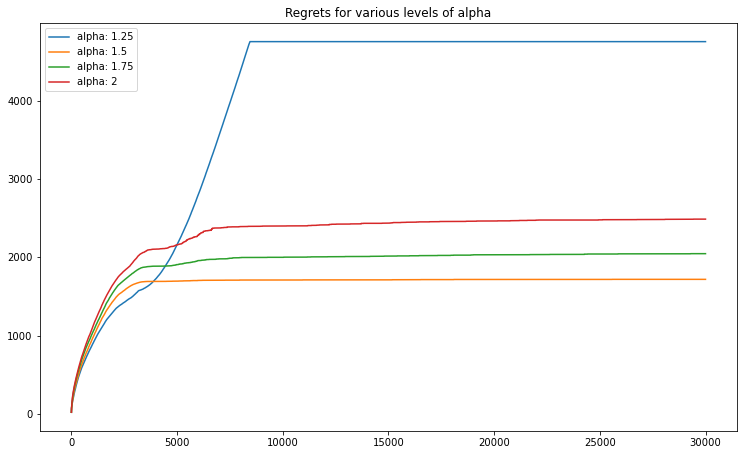

In [17]:
# Plot regrets for various levels of alpha
plt.figure(figsize=(12.5, 7.5))
plot_regrets(results_dict, oracle_case1)
plt.legend()
plt.title("Regrets for various levels of alpha")
plt.show()